# Setting Up the Environment

In [98]:
# Install required packages
!pip install pandas scikit-learn tensorflow matplotlib seaborn statsmodels

In [57]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Collection and Loading

In [58]:
# Data Collection and Loading
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Load the dataset
model_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Project_4/Resources/weather_energy_prep_time.csv')

In [60]:
# Convert date to datetime
model_df['date'] = pd.to_datetime(model_df['date'], format='%Y-%d-%m')

# Set the 'date' column as the index for time series analysis
model_df.set_index('date', inplace=True)

# Extract Month and Year from the date
model_df['Month'] = model_df.index.month
model_df['Year'] = model_df.index.year

In [61]:
# Create 'total_energy_consumption' by summing energy consumption columns
model_df['total_energy_consumption'] = (model_df['coal (kt)'] +
                                         model_df['natural gas (kMcf)'] +
                                         model_df['petroleum coke (kt)'] +
                                         model_df['petroleum liquids (kb)'])

# Create lag feature for energy consumption
model_df['Energy_Lag_1'] = model_df['total_energy_consumption'].shift(1)

In [62]:
# Handle missing values
model_df.fillna(0, inplace=True)

# One-hot encode state variables
model_df = pd.get_dummies(model_df, columns=["st_abb"], drop_first=True)

In [63]:
# Scaling: Apply Min-Max Scaling to selected columns (weather and energy data)
columns_to_scale = ['tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt',
                    'coal (kt)', 'natural gas (kMcf)',
                    'petroleum coke (kt)', 'petroleum liquids (kb)',
                    'Energy_Lag_1'] + [col for col in model_df.columns if 'st_abb' in col]

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the selected columns
model_df[columns_to_scale] = scaler.fit_transform(model_df[columns_to_scale])


# Visualizing the Data

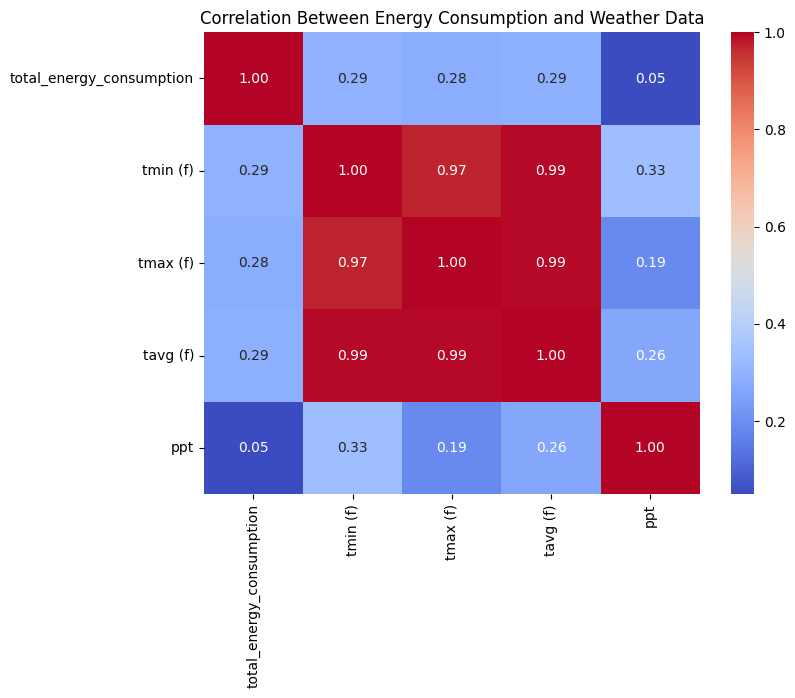

In [64]:
# Calculate correlation between energy consumption and weather variables
correlation = model_df[['total_energy_consumption', 'tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Energy Consumption and Weather Data")
plt.show()

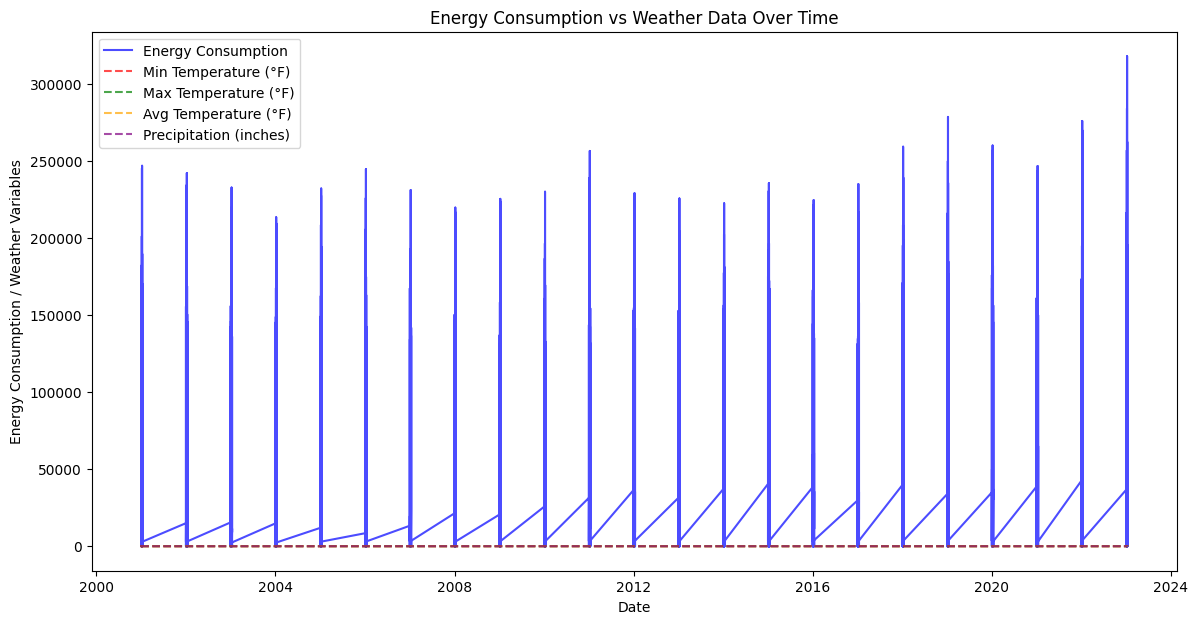

In [65]:
# Plot energy consumption and weather data on the same graph
plt.figure(figsize=(14, 7))

# Plot total energy consumption (in one color)
plt.plot(model_df.index, model_df['total_energy_consumption'], label='Energy Consumption', color='blue', alpha=0.7)

# Plot temperature (min, max, and average) on secondary y-axis
plt.plot(model_df.index, model_df['tmin (f)'], label='Min Temperature (°F)', color='red', linestyle='--', alpha=0.7)
plt.plot(model_df.index, model_df['tmax (f)'], label='Max Temperature (°F)', color='green', linestyle='--', alpha=0.7)
plt.plot(model_df.index, model_df['tavg (f)'], label='Avg Temperature (°F)', color='orange', linestyle='--', alpha=0.7)

# Plot precipitation
plt.plot(model_df.index, model_df['ppt'], label='Precipitation (inches)', color='purple', linestyle='--', alpha=0.7)

# Set labels and title
plt.title('Energy Consumption vs Weather Data Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption / Weather Variables')
plt.legend()
plt.show()

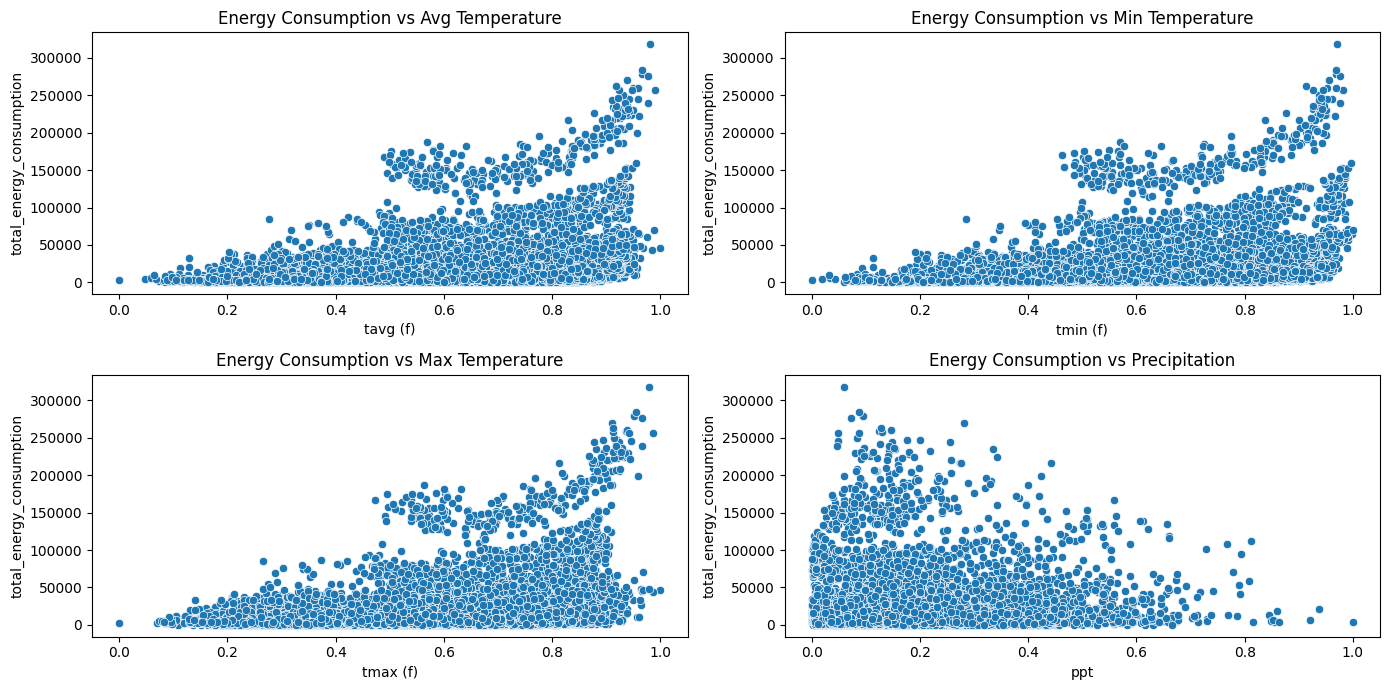

In [66]:
# Scatter plots to examine the relationship between energy consumption and weather variables
plt.figure(figsize=(14, 7))

# Scatter plot for energy consumption vs average temperature
plt.subplot(2, 2, 1)
sns.scatterplot(x=model_df['tavg (f)'], y=model_df['total_energy_consumption'])
plt.title('Energy Consumption vs Avg Temperature')

# Scatter plot for energy consumption vs min temperature
plt.subplot(2, 2, 2)
sns.scatterplot(x=model_df['tmin (f)'], y=model_df['total_energy_consumption'])
plt.title('Energy Consumption vs Min Temperature')

# Scatter plot for energy consumption vs max temperature
plt.subplot(2, 2, 3)
sns.scatterplot(x=model_df['tmax (f)'], y=model_df['total_energy_consumption'])
plt.title('Energy Consumption vs Max Temperature')

# Scatter plot for energy consumption vs precipitation
plt.subplot(2, 2, 4)
sns.scatterplot(x=model_df['ppt'], y=model_df['total_energy_consumption'])
plt.title('Energy Consumption vs Precipitation')

plt.tight_layout()
plt.show()

# Statistical Modeling (using Linear Regression)

In [67]:
# Prepare the data for the model
X = model_df[['tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt']]  # Weather variables
y = model_df['total_energy_consumption']  # Total energy consumption


In [68]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [69]:
# Initialize and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [70]:
# Make predictions
y_pred = model.predict(X_test)



In [71]:
# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 28942.223025913336


# ARIMA Model

In [72]:
# Check for stationarity using ADF test
result = adfuller(model_df['total_energy_consumption'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -11.787908976589215
p-value: 9.985764389730289e-22


In [73]:
# Fit the ARIMA model on the original (stationary) data without differencing
model = ARIMA(model_df['total_energy_consumption'], order=(1, 0, 1))  # Adjust p, d, q if needed
model_fit = model.fit()

# Review the ARIMA model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                                  SARIMAX Results                                   
Dep. Variable:     total_energy_consumption   No. Observations:                13248
Model:                       ARIMA(1, 0, 1)   Log Likelihood             -155426.905
Date:                      Wed, 04 Dec 2024   AIC                         310861.811
Time:                              05:33:15   BIC                         310891.777
Sample:                                   0   HQIC                        310871.814
                                    - 13248                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.831e+04    291.582     62.801      0.000    1.77e+04    1.89e+04
ar.L1          0.5024      0.113      4.432      0.000       0.280       0.725
ma.L

In [74]:
# Forecasting (for the next 'forecast_steps' periods)
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<ipython-input-89-13d0036809f6>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(model_df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')


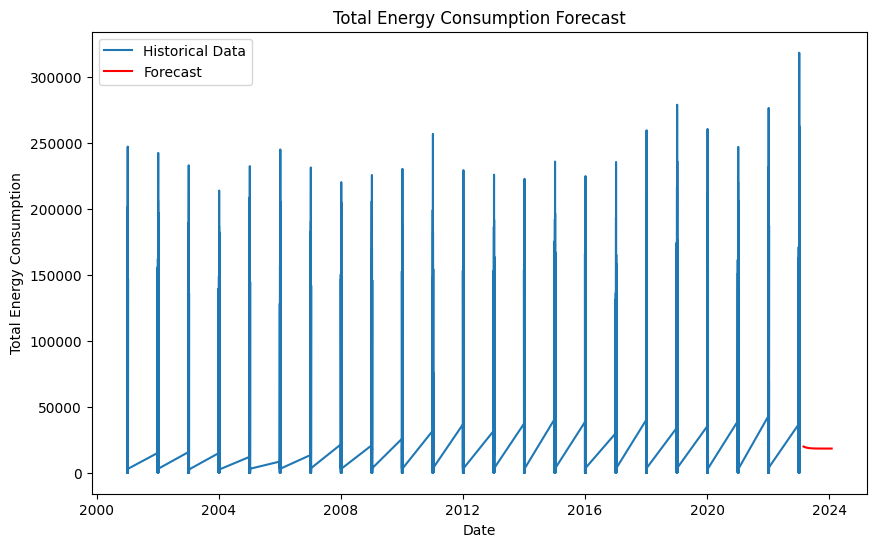

In [89]:
# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(model_df.index, model_df['total_energy_consumption'], label='Historical Data')
plt.plot(pd.date_range(model_df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('Total Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumption')
plt.show()

In [92]:
# Prepare weather data for use as exogenous variables (external regressors)
weather_vars = ['tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt']  # Weather data columns for exogenous vars

# Shift the weather data by 1 to align with the target (energy consumption)
X = model_df[weather_vars].shift(1)  # Shift by 1 to align with the target energy consumption

# Use the original total energy consumption as the target variable (no differencing)
y = model_df['total_energy_consumption'].dropna()

# Drop the first row from the exogenous data (X) to match the length of the target variable (y)
X = X.dropna()

# Drop the last row from y to match the length of X (due to the shift)
y = y.iloc[1:]  # Dropping the first row of the target to match X

# Reset the indices of X and y to remove any date duplication
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Check the alignment of the indices
print("X index:", X.index)
print("y index:", y.index)

X index: RangeIndex(start=0, stop=13247, step=1)
y index: RangeIndex(start=0, stop=13247, step=1)


In [93]:
# Fit the ARIMA model with exogenous variables (weather data)
model = ARIMA(y, exog=X, order=(1, 1, 1))  # (p=1, d=1, q=1)
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                                  SARIMAX Results                                   
Dep. Variable:     total_energy_consumption   No. Observations:                13247
Model:                       ARIMA(1, 1, 1)   Log Likelihood             -155967.177
Date:                      Wed, 04 Dec 2024   AIC                         311948.354
Time:                              05:41:41   BIC                         312000.794
Sample:                                   0   HQIC                        311965.859
                                    - 13247                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmin (f)   -2.838e+07   1.22e+04  -2322.721      0.000   -2.84e+07   -2.84e+07
tmax (f)   -3.107e+07   1.16e+04  -2667.144      0.000   -3.11e+07    -3.1e+07
tavg

In [94]:
# Forecasting
forecast_steps = 12
forecast_dates = pd.date_range(model_df.index[-1], periods=forecast_steps+1, freq='M')[1:]

<ipython-input-94-3238fcb15456>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(model_df.index[-1], periods=forecast_steps+1, freq='M')[1:]


In [95]:
# Prepare the weather data for the forecast period
# Assume you have future weather data for the forecast period
# Example: You may need to forecast future weather based on past trends or use external forecasts
future_weather_data = model_df[weather_vars].iloc[-forecast_steps:].values  # Replace with actual future data

# Forecast using the trained ARIMA model
forecast = model_fit.forecast(steps=forecast_steps, exog=future_weather_data)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

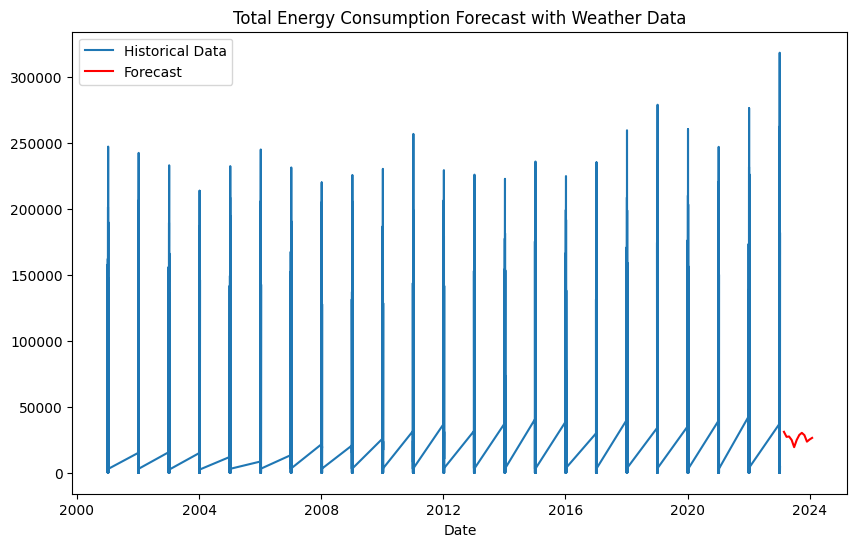

In [96]:
# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(model_df['total_energy_consumption'], label='Historical Data')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Total Energy Consumption Forecast with Weather Data')
plt.xlabel('Date')
plt.ylabel

RMSE: 26604.114935258094
MAE: 26430.237997370572


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

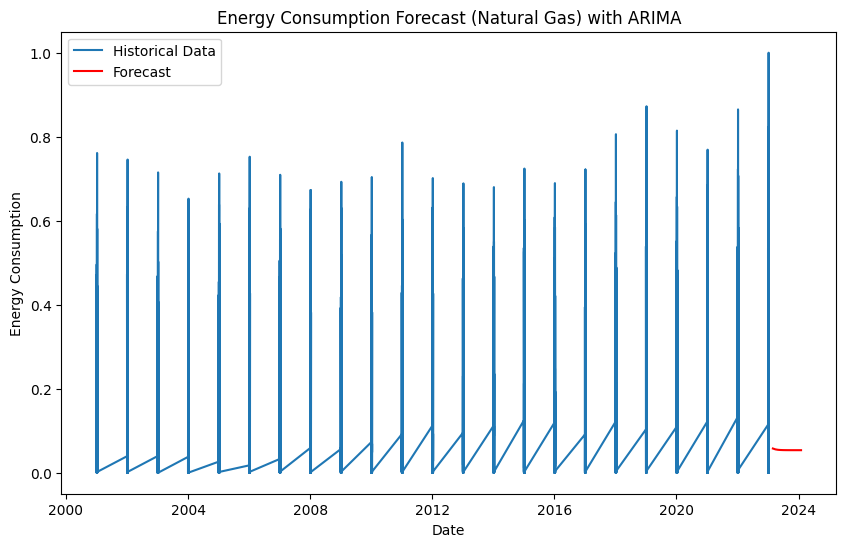

In [97]:
# Model Evaluation (RMSE, MAE)
# Assuming we have actual values for the forecast period
# Here, I assume that `actual_values` are available for the forecast comparison
actual_values = model_df['coal (kt)'].iloc[-forecast_steps:]  # Update based on actual forecast period

mse = mean_squared_error(actual_values, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, forecast)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# If you have multiple energy consumption variables, you can repeat the ARIMA process for each one:
# For example, for 'natural gas (kMcf)', 'petroleum coke (kt)', 'petroleum liquids (kb)', etc.

# Example for 'natural gas (kMcf)'
model_ng = ARIMA(model_df['natural gas (kMcf)'], order=(1, 0, 1))  # d=0 as it's stationary
model_ng_fit = model_ng.fit()
forecast_ng = model_ng_fit.forecast(steps=forecast_steps)

# Plot the forecast for 'natural gas (kMcf)'
plt.figure(figsize=(10, 6))
plt.plot(model_df['natural gas (kMcf)'], label='Historical Data')
plt.plot(pd.date_range(model_df.index[-1], periods=forecast_steps + 1, freq='M')[1:], forecast_ng, label='Forecast', color='red')
plt.legend()
plt.title('Energy Consumption Forecast (Natural Gas) with ARIMA')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()

# Repeat the same for other energy sources as needed